In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from pycaret.classification import * 


In [2]:
train = pd.read_csv('./train.csv').drop_duplicates()
test = pd.read_csv('./test.csv')
test_ids = pd.read_csv('./test_ids.csv')

In [3]:
train['time_stamp'] = pd.to_datetime(train['time_stamp'])

train.loc[:,'month'] = train.loc[:,'time_stamp'].dt.strftime('%m')
train.loc[:,'dayOfMonth'] = train.loc[:,'time_stamp'].dt.strftime('%d')
train.loc[:,'dayofWeek'] = train.loc[:,'time_stamp'].dt.day_name()
train.loc[:,'hour'] = train.loc[:,'time_stamp'].dt.strftime('%H')
train.loc[:,'date'] = train.loc[:,'time_stamp'].dt.strftime('%Y-%m-%d')
train['hour'] = (train['hour']).astype(int)
train['dayOfMonth'] = (train['dayOfMonth']).astype(int)
train['month'] = (train['month']).astype(int)

train['date'] = train['time_stamp'].dt.date
train['date'] = pd.to_datetime(train['date'])

test['time_stamp'] = pd.to_datetime(test['time_stamp'])

test.loc[:,'month'] = test.loc[:,'time_stamp'].dt.strftime('%m')
test.loc[:,'dayOfMonth'] = test.loc[:,'time_stamp'].dt.strftime('%d')
test.loc[:,'dayofWeek'] = test.loc[:,'time_stamp'].dt.day_name()
test.loc[:,'hour'] = test.loc[:,'time_stamp'].dt.strftime('%H')
test.loc[:,'date'] = test.loc[:,'time_stamp'].dt.strftime('%Y-%m-%d')
test['hour'] = (test['hour']).astype(int)
test['dayOfMonth'] = (test['dayOfMonth']).astype(int)
test['month'] = (test['month']).astype(int)

test['date'] = test['time_stamp'].dt.date
test['date'] = pd.to_datetime(test['date'])

In [4]:
def feature_generation(train, test):
    user_vs_action= test.groupby(by=['unique_id', 'user_action'], as_index=False).size()
    user_vs_action = user_vs_action.pivot_table('size', ['unique_id'], 'user_action')
    user_vs_action.reset_index( drop=False, inplace=True ) 
    user_vs_action = user_vs_action[['unique_id', 'favorite', 'order', 'search', 'basket', 'visit']]
    user_vs_action = user_vs_action.fillna(0)

    user_vs_action['total_transaction'] =  (user_vs_action['favorite'] 
                                            + user_vs_action['order'] 
                                            + user_vs_action['search'] 
                                            + user_vs_action['basket'] 
                                            + user_vs_action['visit'] )

    for x in train.user_action.unique().tolist():
        user_vs_action[x + '_percent'] = (
        user_vs_action[x] / user_vs_action['total_transaction']) 

    for x in train.user_action.unique().tolist():
        for y in train.user_action.unique().tolist():
            if x == y:
                continue
            user_vs_action[x + '_over_' + y] = (
            user_vs_action[x] / user_vs_action[y]) 

    for x in train.user_action.unique().tolist():
        for y in train.user_action.unique().tolist():
            if x == y:
                continue
            user_vs_action[x + '_perc_times_' + y + '_perc'] = (
            user_vs_action[x + '_percent'] * user_vs_action[y + '_percent']) 



    user_vs_action.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # product_gender related features_part
    user_vs_action_pgender= test.groupby(by=['unique_id', 'user_action', 'product_gender'], as_index=False, dropna= False).size()

    user_vs_action_pgender = user_vs_action_pgender.fillna('NotDefined')
    user_vs_action_pgender = user_vs_action_pgender.pivot_table('size', ['unique_id'], ['user_action', 'product_gender'])

    list = []
    for x in user_vs_action_pgender.columns:
        list.append(x[0] + '_'+ x[1])
    user_vs_action_pgender.columns = list

    user_vs_action_pgender.reset_index( drop=False, inplace=True ) 

    user_vs_action_pgender = user_vs_action_pgender.fillna(0)



    user_features = pd.merge(user_vs_action, user_vs_action_pgender, on = 'unique_id')

    for x in user_vs_action_pgender.columns:
        if x == 'unique_id':
            continue
        user_features[x + '_percent'] = (
        user_features[x] / user_features[x.split('_')[0]])

    for x in user_vs_action_pgender.columns:
        if x == 'unique_id':
            continue
        for y in user_vs_action_pgender.columns:
            if y == 'unique_id':
                continue
            if x == y:
                continue
            user_features[x + '_over_' + y] = (
            user_features[x] / user_features[y]) 

    for x in user_vs_action_pgender.columns:
        if x == 'unique_id':
            continue
        for y in user_vs_action_pgender.columns:
            if y == 'unique_id':
                continue
            if x == y:
                continue
            user_features[x + '_perc_times_' + y + '_perc'] = (
            user_features[x + '_percent'] * user_features[y + '_percent']) 

    user_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    ### promotion related feature part
    user_vs_action_pgender_in_promotion = train.copy()

    user_vs_action_pgender_in_promotion["in_promotion"]  = user_vs_action_pgender_in_promotion["date"].isin(["2020-11-09", "2020-11-10", "2020-11-11", "2020-11-12", "2020-11-25", "2020-11-26", "2020-11-27" ])


    user_vs_action_pgender_in_promotion= user_vs_action_pgender_in_promotion.groupby(by=['unique_id','in_promotion', 'product_gender'], as_index=False, dropna = False).size()
    user_vs_action_pgender_in_promotion.product_gender = user_vs_action_pgender_in_promotion.product_gender.fillna('NotDefined')

    user_vs_action_pgender_in_promotion = user_vs_action_pgender_in_promotion.pivot_table('size', ['unique_id'], ['product_gender','in_promotion'])

    list = []
    for x in user_vs_action_pgender_in_promotion.columns:
        str_x = 'no_promo'
        if x[1]:
            str_x = "promo"       
        list.append(x[0] + '_'+ str_x )
    user_vs_action_pgender_in_promotion.columns = list

    v1_v2 = user_vs_action_pgender_in_promotion.copy()

    v1_v2 = v1_v2.fillna(0)

    for x in user_vs_action_pgender_in_promotion.columns:
        if x == 'unique_id':
            continue
        if x.split('_')[1] == 'no':
            v1_v2[x + '_percent'] = (
        v1_v2[x] / (v1_v2[x] +  v1_v2[x.split('_')[0] + '_promo']))

        if x.split('_')[1] == 'promo':
            v1_v2[x + '_percent'] = (
        v1_v2[x] / (v1_v2[x] +  v1_v2[x.split('_')[0] + '_no_promo']))
    
    for x in user_vs_action_pgender_in_promotion.columns:
        if x == 'unique_id':
            continue
        for y in user_vs_action_pgender_in_promotion.columns:
            if y == 'unique_id':
                continue
            if x == y:
                continue
            v1_v2[x + '_over_' + y] = (
            v1_v2[x] / v1_v2[y]) 

    for x in user_vs_action_pgender_in_promotion.columns:
        if x == 'unique_id':
            continue
        for y in user_vs_action_pgender_in_promotion.columns:
            if y == 'unique_id':
                continue
            if x == y:
                continue
            v1_v2[x + '_perc_times_' + y + '_perc'] = (
            v1_v2[x + '_percent'] * v1_v2[y + '_percent']) 
            
    v1_v2_ = pd.merge(user_features, v1_v2, on= 'unique_id', how = 'left')
    
    v1_v2_['total_transaction_no_promo'] =  (v1_v2_['Erkek_no_promo'] 
                                            + v1_v2_['Kadın_no_promo'] 
                                            + v1_v2_['NotDefined_no_promo'] 
                                            + v1_v2_['Unisex_no_promo'] )
    v1_v2_['total_transaction_promo'] =  (v1_v2_['Erkek_promo'] 
                                            + v1_v2_['Kadın_promo'] 
                                            + v1_v2_['NotDefined_promo'] 
                                            + v1_v2_['Unisex_promo'] )
    v1_v2_['promo_percent'] = v1_v2_['total_transaction_promo'] / v1_v2_['total_transaction']
    v1_v2_['no_promo_percent'] = v1_v2_['total_transaction_no_promo'] / v1_v2_['total_transaction']
    
    v1_v2_.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    genders = train[['gender', 'unique_id']].drop_duplicates()
    y = pd.merge(user_vs_action[['unique_id']] ,genders, on = 'unique_id', how= 'left').gender
    
    return user_vs_action, user_features, v1_v2_, y

In [5]:
def feature_generation_cluster(train, test, user_vs_action, cluster_col_name):
    
    # cluster_part
    user_vs_action_pgender= test.groupby(by=['unique_id', 'user_action', cluster_col_name], as_index=False, dropna= False).size()

    user_vs_action_pgender = user_vs_action_pgender.fillna('NotDefined')
    user_vs_action_pgender = user_vs_action_pgender.pivot_table('size', ['unique_id'], ['user_action', cluster_col_name])

    list = []
    for x in user_vs_action_pgender.columns:
        list.append(x[0] + '_'+ x[1])
    user_vs_action_pgender.columns = list

    user_vs_action_pgender.reset_index( drop=False, inplace=True ) 

    user_vs_action_pgender = user_vs_action_pgender.fillna(0)

    user_features = pd.merge(user_vs_action, user_vs_action_pgender, on = 'unique_id')

    for x in user_vs_action_pgender.columns:
        if x == 'unique_id':
            continue
        user_features[x + '_percent'] = (
        user_features[x] / user_features[x.split('_')[0]])

    for x in user_vs_action_pgender.columns:
        if x == 'unique_id':
            continue
        for y in user_vs_action_pgender.columns:
            if y == 'unique_id':
                continue
            if x == y:
                continue
            user_features[x + '_over_' + y] = (
            user_features[x] / user_features[y]) 

    for x in user_vs_action_pgender.columns:
        if x == 'unique_id':
            continue
        for y in user_vs_action_pgender.columns:
            if y == 'unique_id':
                continue
            if x == y:
                continue
            user_features[x + '_perc_times_' + y + '_perc'] = (
            user_features[x + '_percent'] * user_features[y + '_percent']) 

    user_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    
        
    genders = train[['gender', 'unique_id']].drop_duplicates()
    y = pd.merge(user_vs_action[['unique_id']] ,genders, on = 'unique_id', how= 'left').gender
    
    return user_features, y

# product cluster version (LAST VERSION) 

In [8]:
clusters_v2 = pd.read_csv('./product_clusters_v2.csv')

#clusters = clusters[clusters['total_transaction'] > 10][['contentid','cluster']]
clusters_v2["cluster"] = "cluster_" +  clusters_v2["cluster"].astype('string')
clusters_v2 = clusters_v2[['Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'businessunit','cluster']]
clusters_v2.columns = ['Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'businessunit','cluster_v2']

In [9]:
#train = pd.merge(train, clusters, on = "contentid", how= 'left')
train = pd.merge(train, clusters_v2, on = ['Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'businessunit'], how= 'left')

In [8]:
feature_set_1, feature_set_2, feature_set_3, y_train = feature_generation(train, train)

In [23]:
feature_set_4, y_train = feature_generation_cluster(train, train, feature_set_1, 'cluster_v2')

In [11]:
#Merge the DataFrames
df_merged = pd.merge(feature_set_3, feature_set_4, how='left', on ='unique_id' , suffixes=('', '_drop'))

#Drop the duplicate columns
df_merged.drop([col for col in df_merged.columns if 'drop' in col], axis=1, inplace=True)

In [12]:
avg_by_user_action = train.groupby(['unique_id', 'user_action']).agg({'sellingprice':['mean']})
avg_by_user_action = avg_by_user_action.pivot_table('sellingprice', ['unique_id'], 'user_action')
avg_by_user_action.columns = avg_by_user_action.columns.droplevel()
avg_by_user_action = avg_by_user_action.reset_index()

avg_by_user_action = avg_by_user_action[['unique_id', 'favorite', 'order', 'search', 'basket', 'visit']]
avg_by_user_action.columns = ['unique_id', 'favorite_sp', 'order_sp', 'search_sp', 'basket_sp', 'visit_sp']
avg_by_user_action = avg_by_user_action.fillna(0)

avg_by_user_action_pg = train.groupby(['unique_id', 'user_action', 'product_gender']).agg({'sellingprice':['mean']})
avg_by_user_action_pg = avg_by_user_action_pg.pivot_table('sellingprice', ['unique_id'], ['user_action', 'product_gender'])

avg_by_user_action_pg.columns = avg_by_user_action_pg.columns.droplevel()
list = []
for x in avg_by_user_action_pg.columns:
    list.append(x[0] + '_'+ x[1] + '_selling_price')
avg_by_user_action_pg.columns = list
avg_by_user_action_pg = avg_by_user_action_pg.reset_index()

avg_by_user_action_cl = train.groupby(['unique_id', 'user_action', 'cluster_v2']).agg({'sellingprice':['mean']})
avg_by_user_action_cl = avg_by_user_action_cl.pivot_table('sellingprice', ['unique_id'], ['user_action', 'cluster_v2'])

avg_by_user_action_cl.columns = avg_by_user_action_cl.columns.droplevel()
list = []
for x in avg_by_user_action_cl.columns:
    list.append(x[0] + '_'+ x[1] + '_selling_price')
avg_by_user_action_cl.columns = list
avg_by_user_action_cl = avg_by_user_action_cl.reset_index()

In [13]:
X_merged = pd.merge(df_merged, avg_by_user_action, how='left', on ='unique_id')
X_merged = pd.merge(X_merged, avg_by_user_action_pg, how='left', on ='unique_id')
X_merged = pd.merge(X_merged, avg_by_user_action_cl, how='left', on ='unique_id')

In [14]:
X = X_merged.fillna(0)

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [24]:
pd_x_scaled = pd.DataFrame(X_scaled)
pd_x_scaled.columns = X.columns

pd_y = pd.DataFrame(y_train)
pd_y['label'] = (pd_y['gender'] == 'F')
pd_y['label'] = (pd_y['label']).astype(int)


data = pd.concat([pd_x_scaled, pd_y['label']],axis = 1)

In [25]:
from pycaret.classification import * 
clf = setup(data,
            target='label',
            fold_shuffle=True,
            remove_outliers = True,
            ignore_features = ['unique_id'],
           fix_imbalance = True,
           combine_rare_levels = True)

,Description,Value
0,session_id,8124
1,Target,label
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5618, 2225)"
5,Missing Values,False
6,Numeric Features,2215
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [26]:
comp = compare_models(include = ['rf', 'gbc'], n_select = 2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7818,0.8523,0.7976,0.8617,0.8282,0.5304,0.5337,1.0440
gbc,Gradient Boosting Classifier,0.7813,0.8575,0.7732,0.8811,0.8234,0.5392,0.5475,6.2210


In [27]:
tuned_gbr = tune_model(comp[1])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7968,0.8509,0.8138,0.8701,0.8410,0.5604,0.5628
1,0.7914,0.8610,0.8219,0.8565,0.8388,0.5437,0.5447
2,0.7807,0.8510,0.7895,0.8667,0.8263,0.5309,0.5352
3,0.7701,0.8412,0.7854,0.8546,0.8186,0.5062,0.5096
4,0.8075,0.8638,0.8340,0.8692,0.8512,0.5788,0.5798
5,0.7775,0.8650,0.8130,0.8439,0.8282,0.5129,0.5136
6,0.7936,0.8703,0.8293,0.8536,0.8412,0.5464,0.5469
7,0.7855,0.8676,0.8049,0.8609,0.8319,0.5366,0.5389
8,0.7855,0.8465,0.8455,0.8320,0.8387,0.5188,0.5189
9,0.7694,0.8475,0.7846,0.8540,0.8178,0.5055,0.5088


# feature importance 

In [28]:
evaluate_model(tuned_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

# Final Model

In [30]:
tuned_gbr

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.049, loss='deviance', max_depth=10,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0005,
                           min_impurity_split=None, min_samples_leaf=5,
                           min_samples_split=7, min_weight_fraction_leaf=0.0,
                           n_estimators=290, n_iter_no_change=None,
                           random_state=8124, subsample=0.4, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

# test set manipulations 

In [35]:
test = pd.merge(test, clusters_v2, on = ['Level1_Category_Name',
        'Level2_Category_Name',
        'Level3_Category_Name',
        'businessunit'], how= 'left')


unseen_data_1, unseen_data_2, unseen_data_3, y_test = feature_generation(test, test)
unseen_data_1 = pd.merge(test_ids, unseen_data_1, on = 'unique_id', how= 'left')
unseen_data_2 = pd.merge(test_ids, unseen_data_2, on = 'unique_id', how= 'left')
unseen_data_3 = pd.merge(test_ids, unseen_data_3, on = 'unique_id', how= 'left')



unseen_data_4, y_test = feature_generation_cluster(test, test, unseen_data_1, 'cluster_v2')

#Merge the DataFrames
unseen_data_5 = pd.merge(unseen_data_3, unseen_data_4, how='left', on ='unique_id' , suffixes=('', '_drop'))

#Drop the duplicate columns
unseen_data_5.drop([col for col in unseen_data_5.columns if 'drop' in col], axis=1, inplace=True)


avg_by_user_action = test.groupby(['unique_id', 'user_action']).agg({'sellingprice':['mean']})
avg_by_user_action = avg_by_user_action.pivot_table('sellingprice', ['unique_id'], 'user_action')
avg_by_user_action.columns = avg_by_user_action.columns.droplevel()
avg_by_user_action = avg_by_user_action.reset_index()

avg_by_user_action = avg_by_user_action[['unique_id', 'favorite', 'order', 'search', 'basket', 'visit']]
avg_by_user_action.columns = ['unique_id', 'favorite_sp', 'order_sp', 'search_sp', 'basket_sp', 'visit_sp']
avg_by_user_action = avg_by_user_action.fillna(0)

avg_by_user_action_pg = test.groupby(['unique_id', 'user_action', 'product_gender']).agg({'sellingprice':['mean']})
avg_by_user_action_pg = avg_by_user_action_pg.pivot_table('sellingprice', ['unique_id'], ['user_action', 'product_gender'])

avg_by_user_action_pg.columns = avg_by_user_action_pg.columns.droplevel()
list = []
for x in avg_by_user_action_pg.columns:
    list.append(x[0] + '_'+ x[1] + '_selling_price')
avg_by_user_action_pg.columns = list
avg_by_user_action_pg = avg_by_user_action_pg.reset_index()

avg_by_user_action_cl = test.groupby(['unique_id', 'user_action', 'cluster_v2']).agg({'sellingprice':['mean']})
avg_by_user_action_cl = avg_by_user_action_cl.pivot_table('sellingprice', ['unique_id'], ['user_action', 'cluster_v2'])

avg_by_user_action_cl.columns = avg_by_user_action_cl.columns.droplevel()
list = []
for x in avg_by_user_action_cl.columns:
    list.append(x[0] + '_'+ x[1] + '_selling_price')
avg_by_user_action_cl.columns = list
avg_by_user_action_cl = avg_by_user_action_cl.reset_index()


X_merged_test = pd.merge(unseen_data_5, avg_by_user_action, how='left', on ='unique_id')
X_merged_test = pd.merge(X_merged_test, avg_by_user_action_pg, how='left', on ='unique_id')
X_merged_test = pd.merge(X_merged_test, avg_by_user_action_cl, how='left', on ='unique_id')

In [36]:
X_merged_test = X_merged_test.fillna(0)
X_test = scaler.transform(X_merged_test)
pd_x_test_scaled = pd.DataFrame(X_test)
pd_x_test_scaled.columns = X.columns
pd_x_test_scaled

,unique_id,favorite,order,search,basket,visit,total_transaction,favorite_percent,visit_percent,search_percent,...,order_cluster_2_selling_price,order_cluster_3_selling_price,search_cluster_0_selling_price,search_cluster_1_selling_price,search_cluster_2_selling_price,search_cluster_3_selling_price,visit_cluster_0_selling_price,visit_cluster_1_selling_price,visit_cluster_2_selling_price,visit_cluster_3_selling_price
0,-1.742594,0.718951,1.801352,5.537829,2.736005,2.756309,3.759765,2.250956,0.271666,-1.683966,...,0.371847,0.564119,0.093462,1.015436,-0.004524,0.201093,0.108730,0.019457,-0.093955,0.022774
1,-1.738695,33.241858,114.822569,72.736841,67.990151,100.477705,90.986598,3.522674,-0.671149,-1.643129,...,0.178463,0.030232,-0.076494,-0.312734,-0.139271,0.241392,-0.094252,0.232634,-0.257377,-0.168309
2,-1.737396,11.873502,2.811372,9.393835,2.159231,10.297011,10.635027,3.023852,-0.536036,-1.696957,...,1.003519,0.199280,-0.098837,0.739089,0.016677,0.422071,-0.028268,0.318431,0.004228,-0.046637
3,-1.735664,10.305593,6.851451,14.165192,4.256592,17.390925,16.297308,3.373974,-0.560250,-1.689033,...,0.003817,0.813015,-0.166060,-0.312734,0.057283,0.617171,0.047354,-0.248567,-0.091337,0.300045
4,-1.733065,22.568879,16.850647,73.681022,73.390856,110.532735,94.776840,3.744402,-0.704303,-1.703045,...,0.656161,0.722811,0.216169,0.634508,0.016885,0.596134,0.180717,0.457649,-0.065103,0.187766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,1.710750,-0.311389,-0.420692,-0.491234,-0.462470,-0.416804,-0.472841,-0.443769,2.364803,-1.713117,...,-0.462792,-0.287200,-0.281402,-0.312734,-0.206763,-0.383864,-0.271653,-0.248567,-0.519877,-0.387506
2376,1.714215,-0.311389,-0.420692,-0.494838,-0.462470,-0.414525,-0.472841,5.948458,-1.880614,-1.713117,...,-0.462792,-0.287200,-0.281402,-0.312734,-0.384270,-0.383864,0.684981,-0.248567,-0.519877,-0.387506
2377,1.715514,-0.311389,-0.420692,-0.494838,-0.462470,-0.414525,-0.472841,5.948458,-1.880614,-1.713117,...,-0.462792,-0.287200,-0.281402,-0.312734,-0.384270,-0.383864,-0.271653,-0.248567,-0.519877,-0.387506
2378,1.715947,-0.311389,-0.319690,-0.494838,-0.462470,-0.416804,-0.472841,-0.443769,-1.880614,2.662200,...,-0.462792,-0.287200,-0.281402,-0.312734,-0.384270,-0.383864,-0.271653,-0.248567,-0.519877,-0.387506


In [37]:
predictions = predict_model(tuned_gbr, data = pd_x_test_scaled)

predictions['score_adj'] = np.where(predictions['Label'] != 1, 1-predictions['Score'] , predictions['Score'])

results = pd.concat([unseen_data_5[['unique_id']], predictions[['score_adj']]], axis = 1)

In [38]:
def change(f):
    if f > 1:
        f = 1
    else:
        if f < 0:
            f = 0
    return str(round(f,3))

# Final Submission

In [39]:
converted_list = [change(element) for element in results.score_adj.tolist()]
",".join(converted_list)

'0.933,0.978,0.963,0.965,0.918,0.99,0.481,0.142,0.93,0.939,0.474,0.115,0.984,0.995,0.971,0.876,0.081,0.206,0.976,0.993,0.972,0.985,0.993,0.966,0.959,0.992,0.989,0.946,0.927,0.963,0.984,0.778,0.941,0.991,0.993,0.957,0.455,0.932,0.967,0.875,0.882,0.914,0.987,0.946,0.929,0.988,0.963,0.258,0.971,0.626,0.048,0.994,0.789,0.009,0.024,0.095,0.959,0.961,0.992,0.789,0.975,0.316,0.091,0.922,0.983,0.819,0.993,0.675,0.952,0.995,0.929,0.969,0.981,0.977,0.643,0.941,0.975,0.979,0.97,0.972,0.095,0.722,0.97,0.046,0.982,0.983,0.942,0.976,0.995,0.916,0.992,0.858,0.973,0.986,0.178,0.891,0.948,0.781,0.924,0.893,0.991,0.987,0.971,0.996,0.882,0.819,0.943,0.486,0.689,0.345,0.723,0.995,0.984,0.983,0.911,0.927,0.329,0.967,0.931,0.978,0.964,0.961,0.193,0.924,0.987,0.843,0.995,0.957,0.03,0.256,0.983,0.306,0.114,0.993,0.988,0.968,0.912,0.99,0.942,0.951,0.574,0.886,0.96,0.994,0.971,0.978,0.76,0.94,0.158,0.885,0.967,0.94,0.996,0.988,0.152,0.993,0.981,0.937,0.99,0.792,0.958,0.743,0.991,0.897,0.979,0.986,0.986,0.99,0.9

# Below is iteration  !!! Iterations !!!

In [ ]:
# test with logistic regression in order to get results in a fast way
# 

In [13]:
model1 = LogisticRegressionCV(cv=10, random_state=0,
                              max_iter = 3000).fit(X_scaled, y_train)

model1.score(X_scaled,y_train) # 0.663937

0.8236027055891777

In [36]:
X = feature_set_1.fillna(0)

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

model1 = LogisticRegressionCV(cv=10, random_state=0,
                              max_iter = 3000).fit(X_scaled, y)

model1.score(X_scaled,y) # 0.663937

0.6723033107867569

In [40]:
X = feature_set_1.fillna(0)

scaler = preprocessing.StandardScaler().fit(pd.concat([feature_set_1, unseen_data_1], axis = 0).fillna(0))
X_scaled = scaler.transform(X)

model1 = LogisticRegressionCV(cv=10, random_state=0,
                              max_iter = 3000).fit(X_scaled, y)

model1.score(X_scaled,y) # 0.663937

0.6698113207547169

In [41]:
X = feature_set_2.fillna(0)

scaler = preprocessing.StandardScaler().fit(pd.concat([feature_set_2, unseen_data_2], axis = 0).fillna(0))
X_scaled = scaler.transform(X)

model1 = LogisticRegressionCV(cv=10, random_state=0,
                              max_iter = 3000).fit(X_scaled, y)

model1.score(X_scaled,y) # 0.663937

0.7981488074047703

In [20]:
X = feature_set_3.fillna(0)

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [78]:
model1 = LogisticRegressionCV(cv=10, random_state=0,
                              max_iter = 3000).fit(X_scaled, y)

model1.score(X_scaled,y) # 0.663937

0.8029547881808473

# Pycaret model 

In [50]:
X = df_merged.fillna(0)

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [15]:
pd_x_scaled = pd.DataFrame(X_scaled)
pd_x_scaled.columns = X.columns

pd_y = pd.DataFrame(y_train)
pd_y['label'] = (pd_y['gender'] == 'F')
pd_y['label'] = (pd_y['label']).astype(int)


data = pd.concat([pd_x_scaled, pd_y['label']],axis = 1)

In [5]:
from sklearn import model_selection
data_train, data_test = model_selection.train_test_split(data, test_size=0.33, random_state=42)

In [79]:
# balancing data (female-male)
balanced_data = pd.concat([data[data['label'] == 0],data[data['label'] == 1].sample(frac = 0.52)], axis = 0)
data_train, data_test = model_selection.train_test_split(balanced_data, test_size=0.33, random_state=42)

In [17]:
from pycaret.classification import * 
clf = setup(data,
            target='label',
            fold_shuffle=True,
            remove_outliers = True,
            ignore_features = ['unique_id'],
           fix_imbalance = True,
           combine_rare_levels = True)

,Description,Value
0,session_id,5637
1,Target,label
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5618, 2185)"
5,Missing Values,False
6,Numeric Features,2183
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


AttributeError: 'Simple_Imputer' object has no attribute 'fill_value_categorical'

In [18]:
comp = compare_models(include = ['rf', 'xgboost', 'gbc'], n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7882,0.8564,0.8106,0.8613,0.8350,0.5401,0.5425,1.0240
gbc,Gradient Boosting Classifier,0.7743,0.8595,0.7657,0.8780,0.8175,0.5251,0.5343,6.7680


In [19]:
model = create_model('rf')

IntProgress(value=0, description='Processing: ', max=4)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,01:33:19
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


/Users/mehmet.yildirim/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmet.yildirim/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/mehmet.yildirim/opt/anaconda3/lib/python3

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGSEGV(-11)}

In [10]:
tuned_gbr = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7649,0.8480,0.7576,0.8681,0.8091,0.5070,0.5150
1,0.7251,0.8011,0.7455,0.8200,0.7810,0.4142,0.4176
2,0.8000,0.8598,0.8788,0.8286,0.8529,0.5413,0.5436
3,0.8520,0.8936,0.8848,0.8902,0.8875,0.6712,0.6712
4,0.8000,0.8858,0.8242,0.8662,0.8447,0.5643,0.5657
5,0.7920,0.8533,0.8182,0.8599,0.8385,0.5469,0.5482
6,0.7680,0.8343,0.8061,0.8365,0.8210,0.4918,0.4924
7,0.7800,0.8527,0.8000,0.8571,0.8276,0.5247,0.5271
8,0.7880,0.8559,0.7927,0.8725,0.8307,0.5490,0.5535
9,0.8040,0.8702,0.8537,0.8485,0.8511,0.5645,0.5645


In [11]:
evaluate_model(tuned_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [20]:
tuned_gbr = tune_model(comp[0])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7620,0.8876,0.6923,0.9293,0.7935,0.5265,0.5588
1,0.7781,0.8976,0.7328,0.9141,0.8135,0.5476,0.5683
2,0.7834,0.8629,0.7368,0.9192,0.8180,0.5585,0.5796
3,0.7487,0.8362,0.6883,0.9091,0.7834,0.4973,0.5251
4,0.7433,0.8593,0.6815,0.9086,0.7788,0.4875,0.5166
5,0.7694,0.8487,0.7166,0.9171,0.8045,0.5336,0.5581
6,0.7775,0.8701,0.7247,0.9227,0.8118,0.5491,0.5734
7,0.7882,0.8687,0.7611,0.9038,0.8264,0.5600,0.5737
8,0.7373,0.8452,0.6761,0.9027,0.7731,0.4759,0.5044
9,0.7534,0.8428,0.6964,0.9101,0.7890,0.5045,0.5311


In [44]:
corr_matrix.to_csv("corr.csv")

In [53]:
comp[0]

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5637, verbose=0,
                       warm_start=False)

In [34]:
unseen_data_5 = unseen_data_5.fillna(0)
X_test = scaler.transform(unseen_data_5)
pd_x_test_scaled = pd.DataFrame(X_test)
pd_x_test_scaled.columns = X.columns
pd_x_test_scaled

,unique_id,favorite,order,search,basket,visit,total_transaction,favorite_percent,visit_percent,search_percent,...,visit_cluster_3_perc_times_order_cluster_3_perc,visit_cluster_3_perc_times_search_NotDefined_perc,visit_cluster_3_perc_times_search_cluster_0_perc,visit_cluster_3_perc_times_search_cluster_1_perc,visit_cluster_3_perc_times_search_cluster_2_perc,visit_cluster_3_perc_times_search_cluster_3_perc,visit_cluster_3_perc_times_visit_NotDefined_perc,visit_cluster_3_perc_times_visit_cluster_0_perc,visit_cluster_3_perc_times_visit_cluster_1_perc,visit_cluster_3_perc_times_visit_cluster_2_perc
0,-1.742594,0.718951,1.801352,5.537829,2.736005,2.756309,3.759765,2.250956,0.271666,-1.683966,...,-0.516801,-0.038871,-0.474441,-0.233073,-0.245961,-0.715154,-0.016146,-0.645911,-0.370357,0.077264
1,-1.738695,33.241858,114.822569,72.736841,67.990151,100.477705,90.986598,3.522674,-0.671149,-1.643129,...,-0.112360,0.025837,0.081991,-0.263285,0.503987,-0.454352,-0.018444,0.000726,-0.343129,1.493696
2,-1.737396,11.873502,2.811372,9.393835,2.159231,10.297011,10.635027,3.023852,-0.536036,-1.696957,...,-0.393148,0.050620,0.183345,-0.180190,0.564134,-0.385140,-0.095049,0.379840,-0.360967,1.197258
3,-1.735664,10.305593,6.851451,14.165192,4.256592,17.390925,16.297308,3.373974,-0.560250,-1.689033,...,1.319292,0.416869,0.800393,-0.302930,0.522134,0.311240,-0.095049,0.818708,-0.333960,1.254491
4,-1.733065,22.568879,16.850647,73.681022,73.390856,110.532735,94.776840,3.744402,-0.704303,-1.703045,...,0.234862,0.134783,0.492079,-0.288148,0.088154,-0.162328,0.013044,0.950269,-0.377770,0.562759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,1.710750,-0.311389,-0.420692,-0.491234,-0.462470,-0.416804,-0.472841,-0.443769,2.364803,-1.713117,...,-0.550798,-0.090207,-0.896477,-0.347575,-0.578464,-0.759562,-0.095049,-1.190862,-0.455853,-0.726949
2376,1.714215,-0.311389,-0.420692,-0.494838,-0.462470,-0.414525,-0.472841,5.948458,-1.880614,-1.713117,...,-0.550798,-0.090207,-0.896477,-0.347575,-0.578464,-0.759562,-0.095049,-1.190862,-0.455853,-0.726949
2377,1.715514,-0.311389,-0.420692,-0.494838,-0.462470,-0.414525,-0.472841,5.948458,-1.880614,-1.713117,...,-0.550798,-0.090207,-0.896477,-0.347575,-0.578464,-0.759562,-0.095049,-1.190862,-0.455853,-0.726949
2378,1.715947,-0.311389,-0.319690,-0.494838,-0.462470,-0.416804,-0.472841,-0.443769,-1.880614,2.662200,...,-0.550798,-0.090207,-0.896477,-0.347575,-0.578464,-0.759562,-0.095049,-1.190862,-0.455853,-0.726949


In [35]:
predictions = predict_model(tuned_gbr, data = pd_x_test_scaled)

predictions = predict_model(comp[0], data = pd_x_test_scaled)

predictions['score_adj'] = np.where(predictions['Label'] != 1, 1-predictions['Score'] , predictions['Score'])

results = pd.concat([unseen_data_5[['unique_id']], predictions[['score_adj']]], axis = 1)

def change(f):
    if f > 1:
        f = 1
    else:
        if f < 0:
            f = 0
    return str(round(f,3))



converted_list = [change(element) for element in results.score_adj.tolist()]
",".join(converted_list)

In [39]:
predictions

,unique_id,favorite,order,search,basket,visit,total_transaction,favorite_percent,visit_percent,search_percent,...,visit_cluster_3_perc_times_search_cluster_0_perc,visit_cluster_3_perc_times_search_cluster_1_perc,visit_cluster_3_perc_times_search_cluster_2_perc,visit_cluster_3_perc_times_search_cluster_3_perc,visit_cluster_3_perc_times_visit_NotDefined_perc,visit_cluster_3_perc_times_visit_cluster_0_perc,visit_cluster_3_perc_times_visit_cluster_1_perc,visit_cluster_3_perc_times_visit_cluster_2_perc,Label,Score
0,-1.742594,0.718951,1.801352,5.537829,2.736005,2.756309,3.759765,2.250956,0.271666,-1.683966,...,-0.474441,-0.233073,-0.245961,-0.715154,-0.016146,-0.645911,-0.370357,0.077264,1,0.8294
1,-1.738695,33.241858,114.822569,72.736841,67.990151,100.477705,90.986598,3.522674,-0.671149,-1.643129,...,0.081991,-0.263285,0.503987,-0.454352,-0.018444,0.000726,-0.343129,1.493696,1,0.8456
2,-1.737396,11.873502,2.811372,9.393835,2.159231,10.297011,10.635027,3.023852,-0.536036,-1.696957,...,0.183345,-0.180190,0.564134,-0.385140,-0.095049,0.379840,-0.360967,1.197258,1,0.8818
3,-1.735664,10.305593,6.851451,14.165192,4.256592,17.390925,16.297308,3.373974,-0.560250,-1.689033,...,0.800393,-0.302930,0.522134,0.311240,-0.095049,0.818708,-0.333960,1.254491,1,0.8713
4,-1.733065,22.568879,16.850647,73.681022,73.390856,110.532735,94.776840,3.744402,-0.704303,-1.703045,...,0.492079,-0.288148,0.088154,-0.162328,0.013044,0.950269,-0.377770,0.562759,1,0.8586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375,1.710750,-0.311389,-0.420692,-0.491234,-0.462470,-0.416804,-0.472841,-0.443769,2.364803,-1.713117,...,-0.896477,-0.347575,-0.578464,-0.759562,-0.095049,-1.190862,-0.455853,-0.726949,0,0.5239
2376,1.714215,-0.311389,-0.420692,-0.494838,-0.462470,-0.414525,-0.472841,5.948458,-1.880614,-1.713117,...,-0.896477,-0.347575,-0.578464,-0.759562,-0.095049,-1.190862,-0.455853,-0.726949,0,0.6199
2377,1.715514,-0.311389,-0.420692,-0.494838,-0.462470,-0.414525,-0.472841,5.948458,-1.880614,-1.713117,...,-0.896477,-0.347575,-0.578464,-0.759562,-0.095049,-1.190862,-0.455853,-0.726949,0,0.5995
2378,1.715947,-0.311389,-0.319690,-0.494838,-0.462470,-0.416804,-0.472841,-0.443769,-1.880614,2.662200,...,-0.896477,-0.347575,-0.578464,-0.759562,-0.095049,-1.190862,-0.455853,-0.726949,0,0.6025


In [118]:
pd_x_scaled = pd.DataFrame(X_scaled)
pd_x_scaled.columns = X.columns
pd_x_scaled

ValueError: Length mismatch: Expected axis has 985 elements, new values have 984 elements

In [59]:
predictions = predict_model(tuned_gbr, data = data_test.drop(columns = ['label']))

predictions = pd.concat([predictions ,data_test['label']], axis = 1)

predictions['is_true_predicted'] = predictions['label'] == ((predictions['Label']> 0.5))

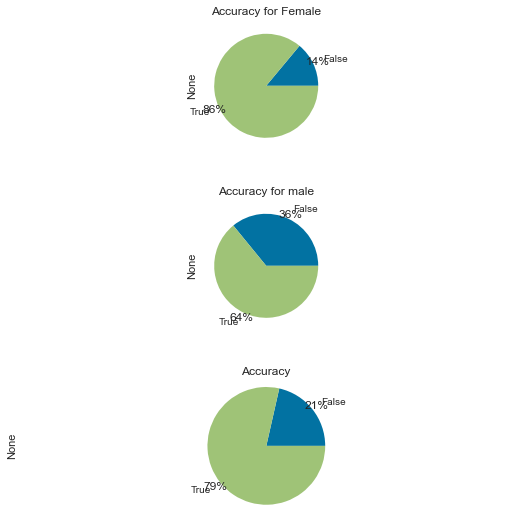

In [124]:
# % 77 accuracy in leaderboard, feature_set_3 is used

fig, axes = plt.subplots(3, figsize=(8, 8))

axes[0].set_title('Accuracy for Female')
predictions[predictions['label']==1].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[0], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[1].set_title('Accuracy for male')
predictions[predictions['label']==0].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[1], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[2].set_title('Accuracy')
predictions.groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[2], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

plt.tight_layout(pad=3);

In [33]:
predictions = predict_model(model, data = data_test.drop(columns = ['label']))

predictions = pd.concat([predictions ,data_test['label']], axis = 1)

predictions['is_true_predicted'] = predictions['label'] == ((predictions['Label']> 0.5))

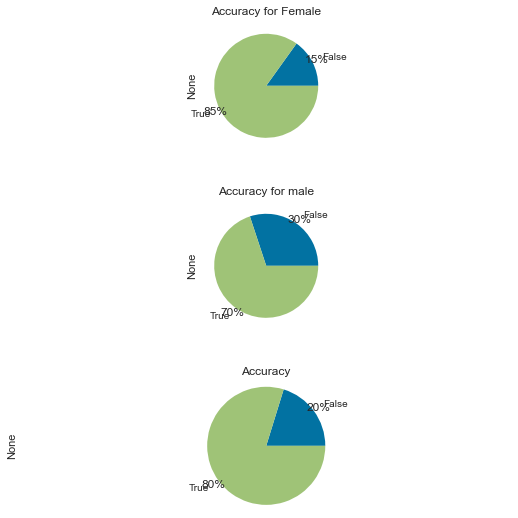

In [34]:
# % 77 accuracy in leaderboard, feature_set_3 is used

fig, axes = plt.subplots(3, figsize=(8, 8))

axes[0].set_title('Accuracy for Female')
predictions[predictions['label']==1].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[0], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[1].set_title('Accuracy for male')
predictions[predictions['label']==0].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[1], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[2].set_title('Accuracy')
predictions.groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[2], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

plt.tight_layout(pad=3);

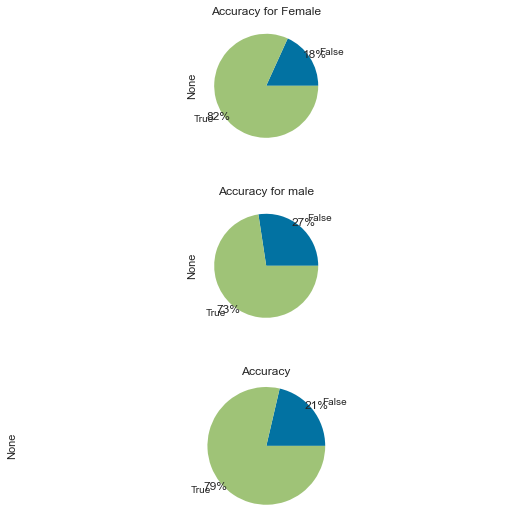

In [13]:
predictions = predict_model(tuned_gbr, data = data_test.drop(columns = ['label']))

predictions = pd.concat([predictions ,data_test['label']], axis = 1)

predictions['is_true_predicted'] = predictions['label'] == ((predictions['Label']> 0.5))

# % ? accuracy in leaderboard, feature_set_4 is used

fig, axes = plt.subplots(3, figsize=(8, 8))

axes[0].set_title('Accuracy for Female')
predictions[predictions['label']==1].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[0], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[1].set_title('Accuracy for male')
predictions[predictions['label']==0].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[1], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[2].set_title('Accuracy')
predictions.groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[2], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

plt.tight_layout(pad=3);

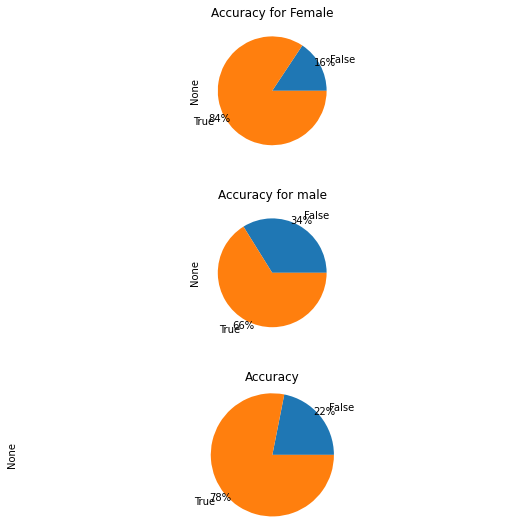

In [62]:
# % ? accuracy in leaderboard, feature_set_4 + 3  is used

fig, axes = plt.subplots(3, figsize=(8, 8))

axes[0].set_title('Accuracy for Female')
predictions[predictions['label']==1].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[0], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[1].set_title('Accuracy for male')
predictions[predictions['label']==0].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[1], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[2].set_title('Accuracy')
predictions.groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[2], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

plt.tight_layout(pad=3);

In [63]:
predictions = predict_model(model, data = data_test.drop(columns = ['label']))

predictions = pd.concat([predictions ,data_test['label']], axis = 1)

predictions['is_true_predicted'] = predictions['label'] == ((predictions['Label']> 0.5))

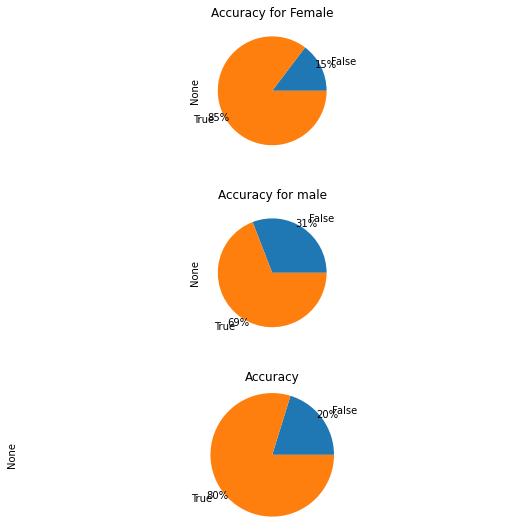

In [64]:
# % ? accuracy in leaderboard, feature_set_4 + 3  is used w/o tuning model

fig, axes = plt.subplots(3, figsize=(8, 8))

axes[0].set_title('Accuracy for Female')
predictions[predictions['label']==1].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[0], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[1].set_title('Accuracy for male')
predictions[predictions['label']==0].groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[1], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

axes[2].set_title('Accuracy')
predictions.groupby(predictions.is_true_predicted).size().plot(kind='pie', ax= axes[2], autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)
plt.axis('equal')

plt.tight_layout(pad=3);